In [2]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append("../../lib")

import os
import numpy as np


import LinOT
import LinOT.Visualization as Vis
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('image', interpolation='nearest')
matplotlib.rc('figure',facecolor='white')
matplotlib.rc('image',cmap='viridis')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
# specify filenames for samples and tangent data
tag="ex1_single-ellipses"
subtag=""
filenameSamples="data/"+tag+"/sample_data.npz"
filenameCenter="data/"+tag+"/center_data"+subtag+".npz"
filenameTan="data/"+tag+"/tan_data"+subtag+".npz"

## Creating some test images

In [4]:
def GetCircleImage(n1,n2,x1,x2,rad,q=1,phi=0,superRes=1):
    if superRes==1:
        res=(n1,n2)
        pos=aux.getPoslistNCube(res,dtype=np.double)
        posCenter=np.array([x1,x2],dtype=np.double)
        pos=pos-posCenter
        img=((np.cos(phi)*pos[:,0]+np.sin(phi)*pos[:,1])/q)**2+\
            ((-np.sin(phi)*pos[:,0]+np.cos(phi)*pos[:,1])*q)**2
        img=(img<=rad**2).astype(dtype=np.double)
        img=img.reshape(res)
        return img
    else:
        res=(superRes*n1,superRes*n2)
        pos=aux.getPoslistNCube(res,dtype=np.double)
        posCenter=np.array([superRes*x1,superRes*x2],dtype=np.double)
        pos=pos-posCenter
        img=((np.cos(phi)*pos[:,0]+np.sin(phi)*pos[:,1])/q)**2+\
            ((-np.sin(phi)*pos[:,0]+np.cos(phi)*pos[:,1])*q)**2
        img=(img<=rad**2*superRes**2).astype(dtype=np.double)
        img=img.reshape((n1,superRes,n2,superRes))
        img=np.sum(img,axis=(1,3))/(superRes**2)
        return img

In [5]:
# moving circles
getargs=lambda s,t : {"n1":64,"n2":64,"x1":32+12*s,"x2":32,"rad":12,\
        "q":1+0.3*t,"phi":0,\
        "superRes":8}

imgList=[]
parList=[]

for s in np.linspace(-1,1,num=5):
    for t in np.linspace(-1,1,num=5):
            img=GetCircleImage(**getargs(s,t))
            imgList.append(img)
            parList.append([s,t])

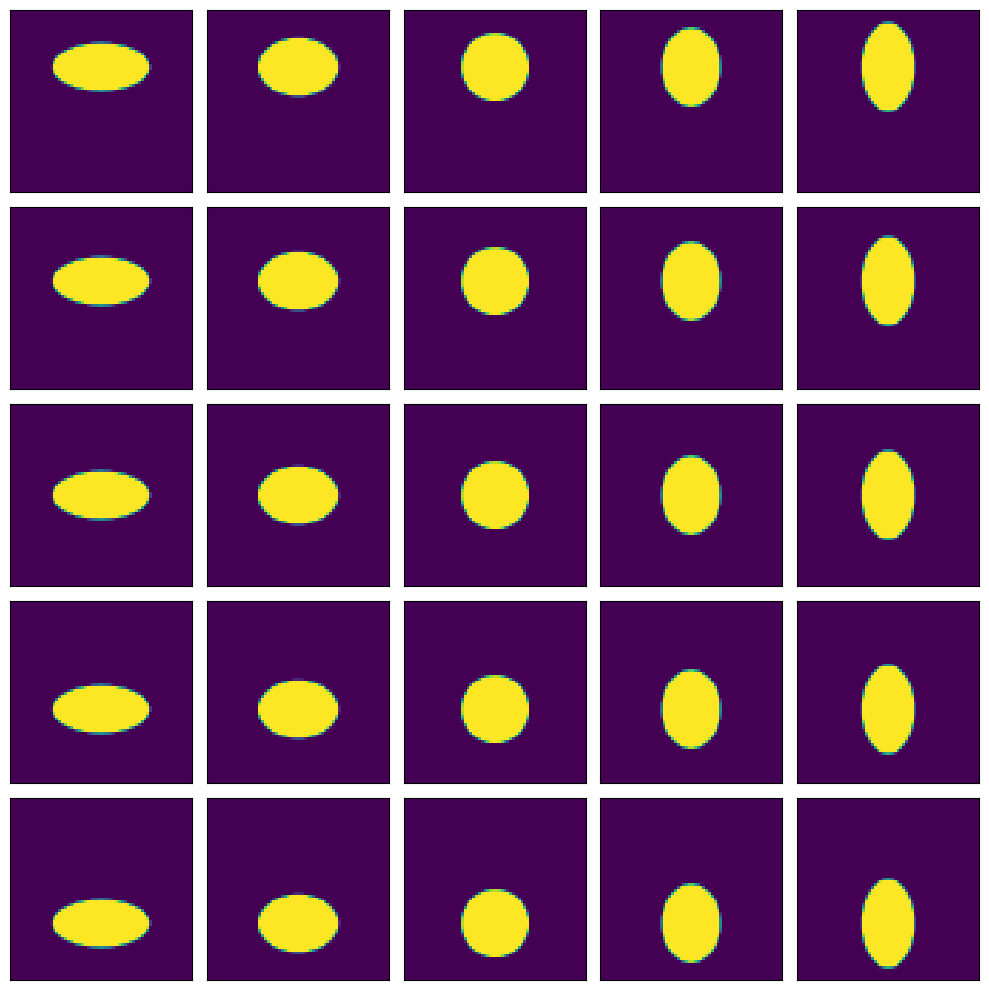

In [6]:
Vis.ShowImageArray(imgList,5,2,2)

In [7]:
# save samples to file
imgList=np.array(imgList)
dirname=os.path.dirname(filenameSamples)
if not os.path.isdir(dirname):
    os.mkdir(dirname)
np.savez_compressed(filenameSamples,imgList=imgList)

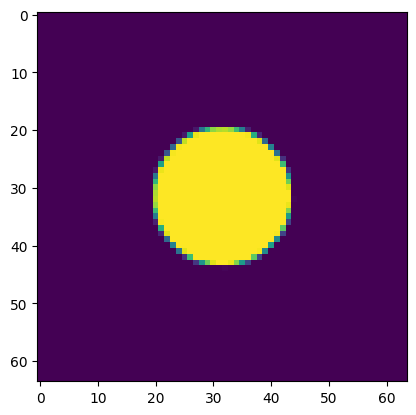

In [8]:
# create center image and save to file
imgCenter=GetCircleImage(**getargs(0,0))
plt.imshow(imgCenter)
plt.show()
np.savez_compressed(filenameCenter,img=imgCenter)

## Load sample data from file

In [9]:
imgList=np.load(filenameSamples)["imgList"]
imgCenter=np.load(filenameCenter)["img"]

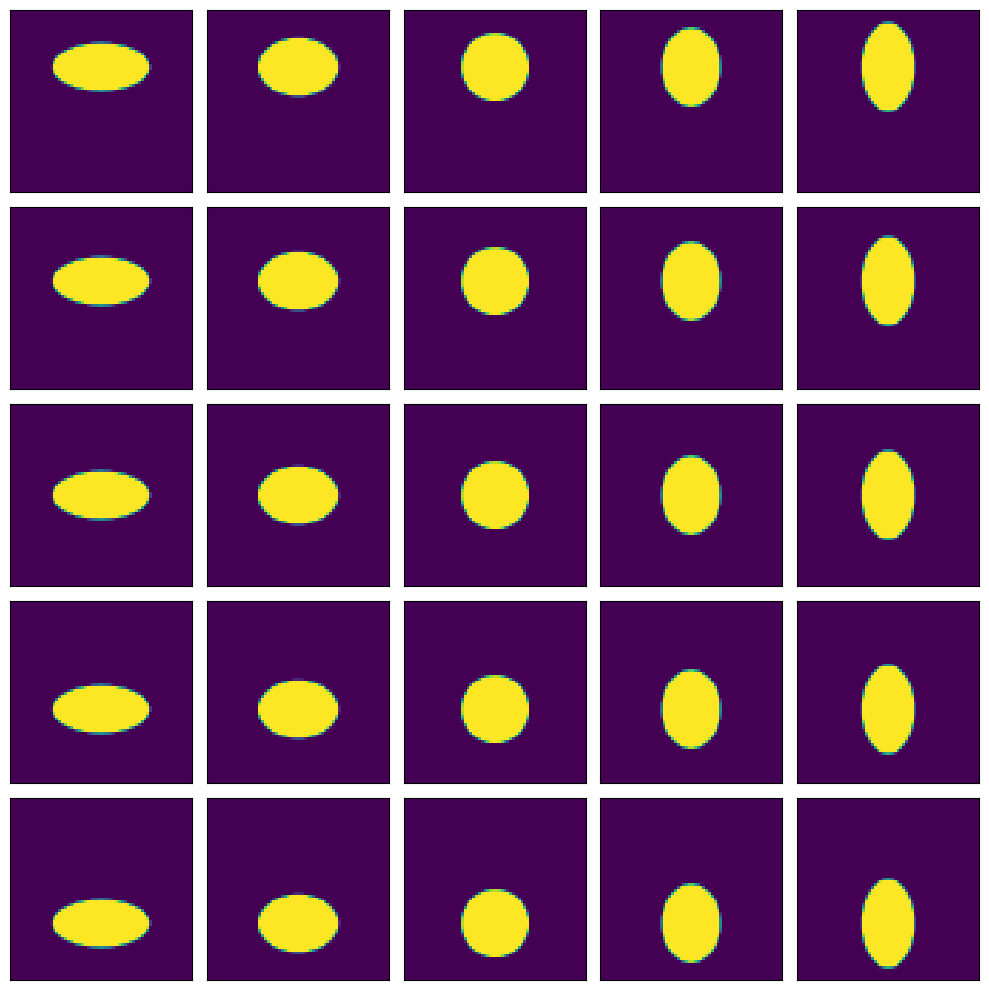

In [10]:
Vis.ShowImageArray(imgList,5,2,2)

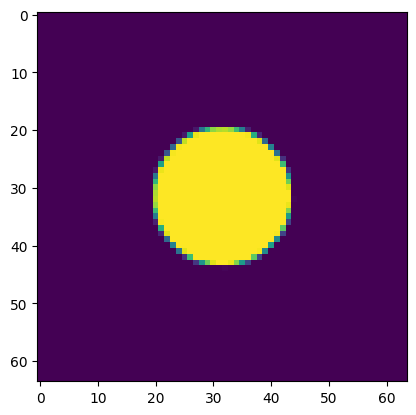

In [11]:
plt.imshow(imgCenter)
plt.show()

In [12]:
# extract point mass data
sampleDat=[aux.processDensity_Grid(img,totalMass=1.,keepZero=False) for img in imgList]
muRef,posRef=aux.processDensity_Grid(imgCenter,totalMass=1.,keepZero=False)

## Solving W2 transport problems and tangent vector extraction via barycentric projection

In [13]:
# solve transport problems
# this should be done once and results saved, just done here to illustrate:
# * basic entropic solver usage
# * and barycentric projection extraction)

In [14]:
params={}
params["solver_errorGoal"]=1.E-3
params["solver_epsStart"]=1E3
params["solver_epsTarget"]=0.1

In [15]:
nSamples=len(sampleDat)
tanList=[]
valueList=[]
posRefD=posRef.astype(np.double)
for i in range(nSamples):
    print(i)
    muSamp=sampleDat[i][0]
    posSampD=sampleDat[i][1].astype(np.double)

    # solve W transport
    value,pi=Sinkhorn.SolveW2(muRef,posRefD,muSamp,posSampD,
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"]
            )
    tanList.append(LinOT.LogW2(pi,posRefD,posSampD))
    valueList.append(value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [16]:
tanList=np.array(tanList)
valueList=np.array(valueList)
np.savez_compressed(filenameTan,tanList=tanList,valueList=valueList)

## Hellinger--Kantorovich mode

In [17]:
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=32
params["solver_errorGoal"]=1.E-2
params["solver_epsStart"]=1E3
params["solver_epsTarget"]=0.1

In [18]:
nSamples=len(sampleDat)
tanListV=[]
tanListAlpha=[]
valueList=[]
posRefD=posRef.astype(np.double)
for i in range(nSamples):
    print(i)
    muSamp=sampleDat[i][0]
    posSampD=sampleDat[i][1].astype(np.double)

    # solve HK transport
    value,piCSR=Sinkhorn.SolveHK(muRef,posRefD,muSamp,posSampD,HKScale=params["setup_HKScale"],
                SinkhornError=params["solver_errorGoal"],
                epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"]
                )

    v,alpha=LinOT.LogHK(piCSR,muRef,posRefD,posSampD,kappa=params["setup_HKScale"])
    tanListV.append(v)
    tanListAlpha.append(alpha)
    valueList.append(value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [19]:
tanList=np.array(tanList)
valueList=np.array(valueList)
filename="data/"+tag+"/tan_data"+subtag+"_HK_kappa32.npz"
np.savez_compressed(filename,tanListV=tanListV,tanListAlpha=tanListAlpha,valueList=valueList)